In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "happiness_over_countries"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import unicodedata
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import re
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
import string
import csv
from pyspark.sql.types import StringType
from pyspark.sql.types import ArrayType

In [3]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("nlp")\
    .config("spark.executor.memory", "32g")\
    .config("spark.driver.memory", "32g")\
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","16g")\
    .config("spark.debug.maxToStringFields","200")\
    .getOrCreate()

In [4]:
import tarfile
from six.moves import urllib
          

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/hadiaskari1981/sentiment_analysis/master/"
DATASETS_PATH = os.path.join("datasets")
DOWNLOAD_URL = DOWNLOAD_ROOT + "datasets/datasets.tar.gz"
TWEETS_PATH = os.path.join("datasets", "tweets")


def fetch_housing_data(download_url=DOWNLOAD_URL, datasets_path=DATASETS_PATH):
    if not os.path.isdir(datasets_path):
        os.makedirs(datasets_path)
    tgz_path = os.path.join(datasets_path, "datasets.tar.gz")
    urllib.request.urlretrieve(download_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=datasets_path)
    housing_tgz.close()


In [5]:
def load_data(path, join):
    csv_path = os.path.join(path,join)
    return spark.read.csv(csv_path, inferSchema=True, encoding = 'utf8', header=True)

In [5]:
fetch_housing_data()

In [ ]:
tweets = load_data(TWEETS_PATH, '*.csv')
tweets = tweets.selectExpr( "_c1 as text" , "_c12 as location")
tweets.show(2)

In [6]:
latitude_longitude= load_data(DATASETS_PATH, 'country_capitals.csv')
latitude_longitude= latitude_longitude.select('countryName','capitalLatitude','capitalLongitude')
latitude_longitude.show(2)

+--------------------+---------------+----------------+
|         countryName|capitalLatitude|capitalLongitude|
+--------------------+---------------+----------------+
|          Somaliland|           9.55|           44.05|
|South Georgia and...|     -54.283333|           -36.5|
+--------------------+---------------+----------------+
only showing top 2 rows



In [ ]:
# Remove https in the text
def remove_https(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    return text
udfhttps=udf(lambda text: remove_https(text), StringType())
tweets = tweets.withColumn("text", udfhttps(tweets["text"]))

In [ ]:
split_col = split(tweets['location'], ':')
tweets = tweets.withColumn('location_name', split_col.getItem(1))

In [ ]:
def normalizeData(text):    
    text = unicodedata.normalize('NFKD', str(text))
    text = text.replace(r'\n', '')
    text = ' '.join(text.split())
    replace_punctuation = str.maketrans(string.punctuation,' '*len(string.punctuation))
    text = text.translate(replace_punctuation)
    text = text.encode('ASCII', 'ignore')
    text = text.decode('unicode_escape')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

udfNormalizeData=udf(lambda text: normalizeData(text), StringType())

tweets = tweets.withColumn("text", udfNormalizeData(tweets["text"]))
tweets = tweets.withColumn("location_name", udfNormalizeData(tweets["location_name"]))

In [ ]:
tweets.show(2)

In [ ]:
LATIN_1_CHARS = (
    (' xe2 x80 x99', "'"),
    (' xc3 xa9', 'e'),
    (' xe2 x80 x90', '-'),
    (' xe2 x80 x91', '-'),
    (' xe2 x80 x92', '-'),
    (' xe2 x80 x93', '-'),
    (' xe2 x80 x94', '-'),
    (' xe2 x80 x94', '-'),
    (' xe2 x80 x98', "'"),
    (' xe2 x80 x9b', "'"),
    (' xe2 x80 x9c', '"'),
    (' xe2 x80 x9c', '"'),
    (' xe2 x80 x9d', '"'),
    (' xe2 x80 x9e', '"'),
    (' xe2 x80 x9f', '"'),
    #(' xe2 x80 xa6', '...'),
    (' xe2 x80 xa6', ''),
    (' xe2 x80 xb2', "'"),
    (' xe2 x80 xb3', "'"),
    (' xe2 x80 xb4', "'"),
    (' xe2 x80 xb5', "'"),
    (' xe2 x80 xb6', "'"),
    (' xe2 x80 xb7', "'"),
    (' xe2 x81 xba', "+"),
    (' xe2 x81 xbb', "-"),
    (' xe2 x81 xbc', "="),
    (' xe2 x81 xbd', "("),
    (' xe2 x81 xbe', ")"),
    (' xe2 x80 xa7', "."),
    ('.', " "),
)
def clean_latin1(data):
    for _hex, _char in LATIN_1_CHARS:
        data = data.replace(_hex, _char)
    return data

In [ ]:
udfDecoding=udf(lambda text: clean_latin1(text), StringType())
tweets = tweets.withColumn("text", udfDecoding(tweets["text"]))

In [13]:
def lower_words(df):
    fields = df.schema.fields
    stringFields = filter(lambda f: isinstance(f.dataType, StringType), fields)
    nonStringFields = map(lambda f: col(f.name), filter(lambda f: not isinstance(f.dataType, StringType), fields))
    stringFieldsTransformed = map(lambda f: lower(col(f.name)).alias(f.name), stringFields) 
    allFields = [*nonStringFields, *stringFieldsTransformed]
    df = df.select(allFields)
    return df

In [ ]:
tweets= lower_words(tweets)
tweet= tweets.where(tweets.location.isNotNull())
tweets = tweets.drop('location')

In [ ]:
def regexTokenizer_StopWordsRemover(df, inputCol, outputCol1, outputCol2, ):
    # the input od the stop words is the outputCol1 from tokenizer
    # inputCol and outputCol should be in string format
    regexTokenizer = RegexTokenizer(minTokenLength= 3, inputCol=inputCol, outputCol=outputCol1, pattern="\\W")
    df = regexTokenizer.transform(df)
    remover = StopWordsRemover(inputCol=outputCol1, outputCol=outputCol2)
    df = remover.transform(df).drop(inputCol, outputCol1)
    return df

In [ ]:
tweets= regexTokenizer_StopWordsRemover(tweets, 'text', 'words_','words')
tweets.show(3)

In [ ]:
def remove_emoji(df, inputCol, outputCol):
    with open(os.path.join(DATASETS_PATH,'emoji.txt'), 'r') as f:
        first_list=f.read().strip().splitlines()

    second_list = []
    for item in first_list:
        x = item.split('\\')
        second_list.append(x)

    third_list = []
    for item in second_list:
        new_list = []
        for e in item:
            if e not in (''):
                new_list.append(e)
        third_list.append(new_list)

    fourth_list = [item for sublist in third_list for item in sublist]

    emojies = []
    for word in fourth_list:   #for each word in line.split()
        if word not in emojies:    #if a word isn't in line.split            
            emojies.append(word.lower())

    remover = StopWordsRemover(inputCol=inputCol, outputCol=outputCol, stopWords=emojies)
    df = remover.transform(df).drop(inputCol).withColumnRenamed(outputCol, inputCol)
    return df                                                     

In [ ]:
tweets = remove_emoji(tweets, "words","words_")

In [ ]:
regexTokenizer = RegexTokenizer(minTokenLength= 3, inputCol="location_name",\
                                outputCol="location_name_token", pattern="\\W")

tweets = regexTokenizer.transform(tweets)
tweets= tweets.where(size(col("location_name_token")) >0)

join_udf = udf(lambda x: " ".join(x))

tweets=tweets.withColumn("location_name_token", join_udf(col("location_name_token")))
tweets = tweets.drop('text', 'location_name')
tweets=tweets.selectExpr('location_name_token as location', 'words as words' )

In [ ]:
def change_city_with_country(df, nameCol='location'):
    
    list_city_country=load_data(DATASETS_PATH,"GeoLite2-City-Locations-en.csv")
    list_city_country.drop_duplicates(["city_name"])
    list_city_country=list_city_country.filter("city_name is not NULL")

    list_city = [i.city_name for i in list_city_country.collect()]
    list_country = [i.country_name for i in list_city_country.collect()]

    list_city = [''.join(c for c in s if c not in string.punctuation) for s in list_city]
    list_country = [''.join(c for c in s if c not in string.punctuation) for s in list_country]


    list_city = [x.lower() for x in list_city]
    list_country = [x.lower() for x in list_country]
    
    df_pd = df.toPandas()
    df_pd = df_pd[df_pd[nameCol].isin(list_city)]
    
    for pos, word in enumerate(list_city):
        df_pd.loc[df_pd.location == word, 'location'] = list_country[pos]
    
    sqlCtx = SQLContext(sc)
    df=sqlCtx.createDataFrame(df_pd)
    return df

In [ ]:
tweets = change_city_with_country(tweets)

In [ ]:
tweets.show(2)

In [ ]:
tweets.repartition(1).write.json(os.path.join(DATASETS_PATH,'tweets_location'))

## Clean Dataset contains locations and tweets

In [ ]:
tweets_location = spark.read.json(os.path.join(DATASETS_PATH, "tweets_location", "tweets_location.json"))

In [ ]:
def avg_happiness_of_words(df,nameCol_to_explode):
    h_avg = sc.textFile(os.path.join(DATASETS_PATH, "Data_Set_S1.txt"))\
           .mapPartitions(lambda line: csv.reader(line,delimiter='\t', quotechar='"'))\
           .filter(lambda line: len(line)>=2 and line[0]!= 'word')\
           .toDF(["word", "happiness_rank", "happiness_average",\
                  "happiness_standard_deviation", "twitter_rank",\
                  "google_rank", "nyt_rank", "lyrics_rank"])

    happiness_words = h_avg.select('word').collect()
    happiness_average = h_avg.select('happiness_average').collect()
    happiness_words = [str(row.word) for row in happiness_words]
    happiness_average = [float(row.happiness_average) for row in happiness_average]
    
    nameCols = df.columns
    df=df.withColumn('row_index', F.monotonically_increasing_id()).select(["row_index"]+nameCols)
    
    df_explode = df.withColumn("elements", explode(nameCol_to_explode))
    df_explode_pd = df_explode.toPandas()
    
    for pos, word in enumerate(happiness_words):
        if happiness_average[pos] <= 3.5 or happiness_average[pos] >=6.5 :
            df_explode_pd.loc[df_explode_pd.elements == word, 'happiness_score'] = happiness_average[pos]
    
    df_explode_pd_n = df_explode_pd.dropna()
    
    sqlCtx = SQLContext(sc)
    df_explode=sqlCtx.createDataFrame(df_explode_pd_n)
        
    df_ = df_explode.orderBy("row_index").groupBy("row_index" ).agg(collect_list("happiness_score"))
    df_ = df_.select(col("row_index").alias("row_index"),\
                         col("collect_list(happiness_score)").alias("happiness_score"))
    
    df_join = df.join(df_, on='row_index', how = 'inner').sort('row_index').drop('row_index')
    
    def mean_list(x):
        summation = 0.00
        for val in x:
            
            summation = float(summation) + float(val)
        return [float(summation)/float(len(x))]

    mean_list_udf = udf(lambda y: mean_list(y), ArrayType(FloatType()))
    
    df = df_join.withColumn('happiness_avg', mean_list_udf('happiness_score'))
    df_final= df.withColumn("happiness_avg", explode('happiness_avg'))

    return df_final   
    

In [ ]:
df_countries_happiness = avg_happiness_of_words(tweets_location, 'words')

In [ ]:
df.repartition(1).write.json(os.path.join(DATASETS_PATH,'countries_happiness'))

## Start

In [7]:
countries_happiness = spark.read.json('./datasets/countries_happiness/countries_happiness.json')

In [8]:
countries_happiness.show(2)

+-------------+--------------------+--------------+--------------------+
|happiness_avg|     happiness_score|      location|               words|
+-------------+--------------------+--------------+--------------------+
|    6.5933332|[6.92, 3.74, 6.22...|united kingdom|[game, last, nigh...|
|          7.1|   [6.18, 7.1, 8.02]|         india|[roynemer, tomorr...|
+-------------+--------------------+--------------+--------------------+
only showing top 2 rows



In [9]:
def avg_happiness_over_country(df, groupby_col, happiness_avg_over_words_col):
    df = df.groupBy(groupby_col).agg(collect_list(happiness_avg_over_words_col).alias("avg_happiness_country"))
    def mean_list(x):
        summation = 0.00
        for val in x:
            if val< 4 or val > 6:
                summation = float(summation) + float(val)
        return [float(summation)/float(len(x))]

    mean_list_udf = udf(lambda y: mean_list(y), ArrayType(FloatType()))

    df = df.withColumn('avg_happiness_country', mean_list_udf('avg_happiness_country'))
    df = df.withColumn("avg_happiness_country", explode('avg_happiness_country'))
    
    return df

In [10]:
df_final = avg_happiness_over_country(countries_happiness, 'location', 'happiness_avg')

In [11]:
df_final.show(2)

+--------+---------------------+
|location|avg_happiness_country|
+--------+---------------------+
|   aruba|              6.17211|
| finland|             6.114384|
+--------+---------------------+
only showing top 2 rows



In [14]:
latitude_longitude = lower_words(latitude_longitude)
latitude_longitude = lower_words(latitude_longitude)
latitude_longitude = latitude_longitude.selectExpr('countryName as location',\
                                                   'capitalLongitude as longitude',\
                                                   'CapitalLatitude as latitude')

In [15]:
df = df_final.join(latitude_longitude, on='location', how = 'inner').sort('location')

In [16]:
df = df.withColumn("latitude", df["latitude"].cast("float"))
df = df.withColumn("longitude", df["longitude"].cast("float"))

In [17]:
df_pd = df.toPandas()

Saving figure bad_visualization_plot


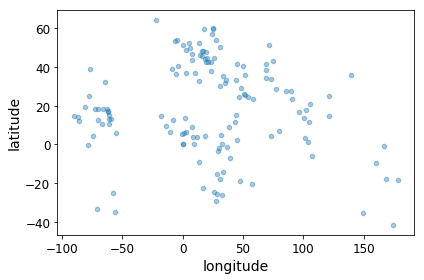

In [18]:
df_pd.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


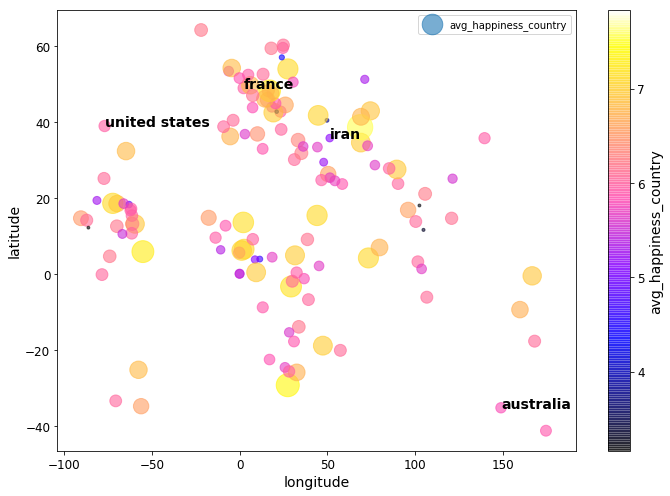

In [23]:
ax = df_pd.plot(kind="scatter", x="longitude", y="latitude", alpha=0.6,
    s= np.exp(df_pd["avg_happiness_country"])/3, label="avg_happiness_country",
    figsize=(10,7), c="avg_happiness_country", cmap=plt.get_cmap("gnuplot2"), colorbar=True,
    sharex=False)

for i, txt in enumerate(df_pd.location):
    if txt == 'iran' or txt == 'united states' or txt == 'france' or txt == 'australia':
        ax.annotate(txt, (df_pd.longitude.iat[i], df_pd.latitude.iat[i]), fontsize=14 ,fontweight ='bold')

save_fig("better_visualization_plot")
plt.show()

In [20]:
lat = df_pd['latitude'].values
lon = df_pd['longitude'].values
avg_hap = df_pd['avg_happiness_country'].values
location = df_pd['location'].values

In [21]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

Saving figure good_visualization_plot


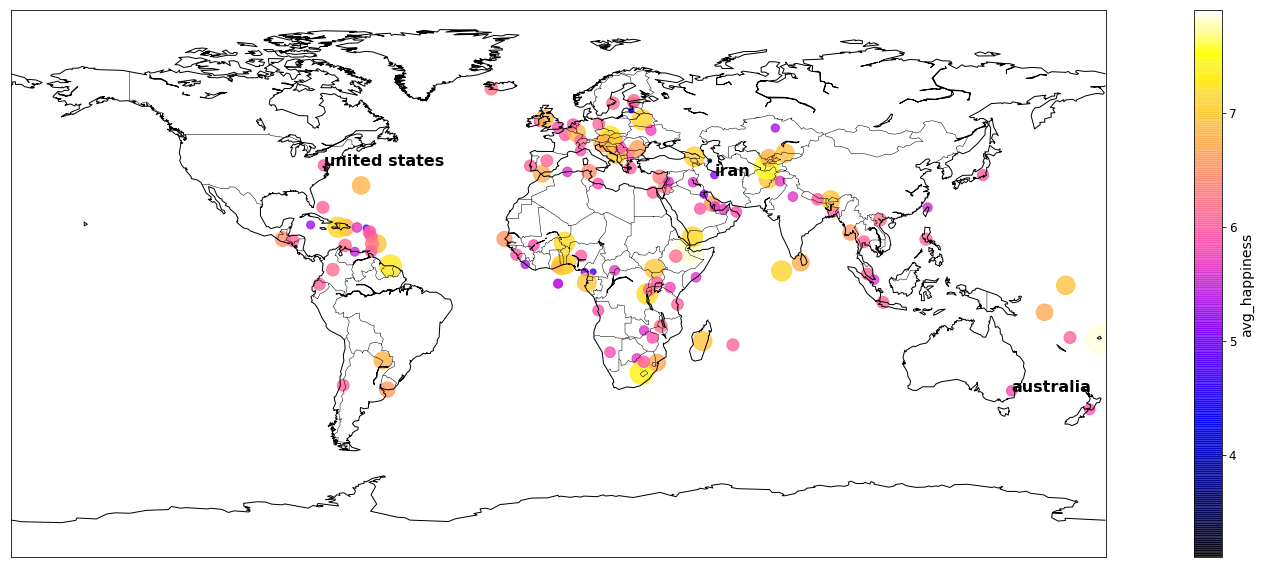

In [22]:
fig = plt.figure(figsize=(25, 8))
map = Basemap()
map.drawcoastlines()
#map.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
#map.drawmapboundary(fill_color="#DDEEFF")
map.drawcountries()



map.scatter(lon, lat, latlon=True,
          c= avg_hap, s= np.exp(avg_hap)/3,
          cmap=plt.get_cmap("gnuplot2"), alpha=0.8)

plt.colorbar(label='avg_happiness')
plt.clim(3.1,7.9 )


for i, txt in enumerate(df_pd.location):
    if txt == 'iran' or txt == 'united states' or txt == 'australia':
        plt.annotate(txt, (df_pd.longitude.iat[i], df_pd.latitude.iat[i]), fontsize = 16 ,fontweight='bold')
        
save_fig("good_visualization_plot")

plt.show()

Saving figure best_visualization_plot


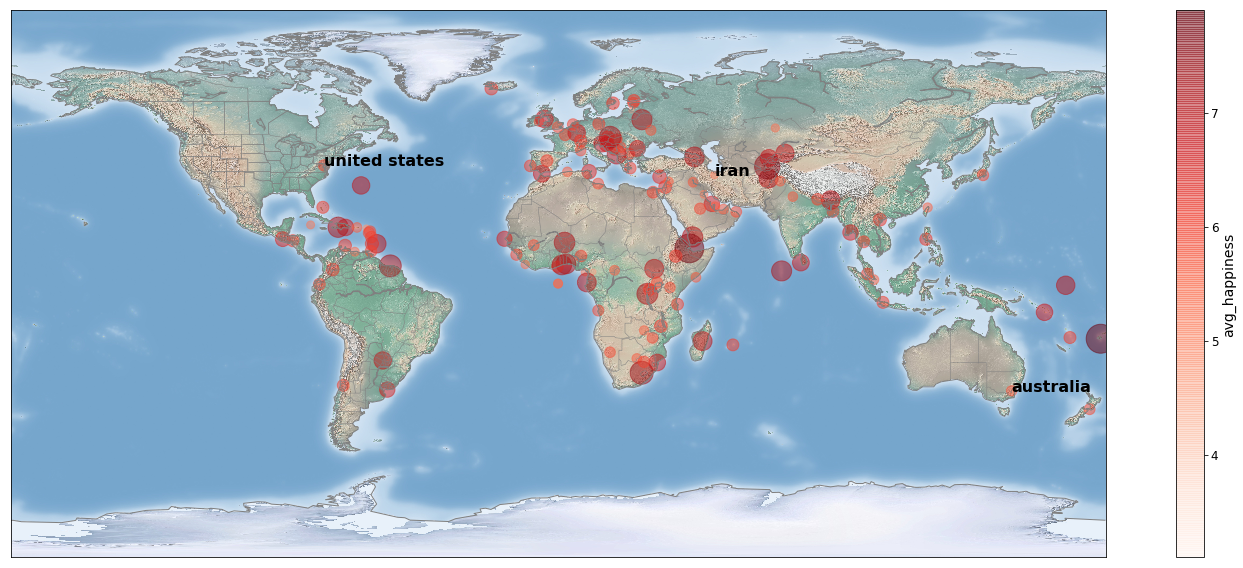

In [24]:
# 1. Draw the map background

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20, 8))
m = Basemap()

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c= avg_hap, s=np.exp(avg_hap)/3,
          cmap='Reds', alpha=0.5)

plt.colorbar(label='avg_happiness')
plt.clim(3.1,7.9 )


for i, txt in enumerate(df_pd.location):
    if txt == 'iran' or txt == 'united states' or txt == 'australia':
        plt.annotate(txt, (df_pd.longitude.iat[i], df_pd.latitude.iat[i]), fontsize = 16 ,fontweight='bold')
        
save_fig("best_visualization_plot")


## The End